<a href="https://colab.research.google.com/github/Leonild/TimeSeriesDataAnalysis/blob/main/%5BPhD%5DTimeSeries.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Getting the data and Unzip
https://aqs.epa.gov/aqsweb/airdata/download_files.html

In [ ]:
# Ozone
!wget https://aqs.epa.gov/aqsweb/airdata/daily_44201_2022.zip
# !wget https://aqs.epa.gov/aqsweb/airdata/daily_44201_2021.zip
# !wget https://aqs.epa.gov/aqsweb/airdata/daily_44201_2020.zip
# !wget https://aqs.epa.gov/aqsweb/airdata/daily_44201_2019.zip
# !wget https://aqs.epa.gov/aqsweb/airdata/daily_44201_2018.zip
# !wget https://aqs.epa.gov/aqsweb/airdata/daily_44201_2017.zip
# !wget https://aqs.epa.gov/aqsweb/airdata/daily_44201_2016.zip
# !wget https://aqs.epa.gov/aqsweb/airdata/daily_44201_2015.zip
# !wget https://aqs.epa.gov/aqsweb/airdata/daily_44201_2014.zip
# !wget https://aqs.epa.gov/aqsweb/airdata/daily_44201_2013.zip
# !wget https://aqs.epa.gov/aqsweb/airdata/daily_44201_2012.zip
# !wget https://aqs.epa.gov/aqsweb/airdata/daily_44201_2011.zip
# !wget https://aqs.epa.gov/aqsweb/airdata/daily_44201_2010.zip
# !wget https://aqs.epa.gov/aqsweb/airdata/daily_44201_2009.zip
# !wget https://aqs.epa.gov/aqsweb/airdata/daily_44201_2008.zip
# !wget https://aqs.epa.gov/aqsweb/airdata/daily_44201_2007.zip

--2023-12-13 03:36:42--  https://aqs.epa.gov/aqsweb/airdata/daily_44201_2022.zip
Resolving aqs.epa.gov (aqs.epa.gov)... 134.67.21.26, 2620:117:506f:15::f01a
Connecting to aqs.epa.gov (aqs.epa.gov)|134.67.21.26|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4556664 (4.3M) [application/zip]
Saving to: ‘daily_44201_2022.zip’

daily_44201_2022.zi 100%[===================>]   4.34M  1.23MB/s    in 3.5s    

2023-12-13 03:36:46 (1.23 MB/s) - ‘daily_44201_2022.zip’ saved [4556664/4556664]



In [ ]:
!unzip daily_44201_2022.zip -d data
# !unzip daily_44201_2021.zip -d data
# !unzip daily_44201_2020.zip -d data
# !unzip daily_44201_2019.zip -d data
# !unzip daily_44201_2018.zip -d data
# !unzip daily_44201_2017.zip -d data
# !unzip daily_44201_2016.zip -d data
# !unzip daily_44201_2015.zip -d data
# !unzip daily_44201_2014.zip -d data
# !unzip daily_44201_2013.zip -d data
# !unzip daily_44201_2012.zip -d data
# !unzip daily_44201_2011.zip -d data
# !unzip daily_44201_2010.zip -d data
# !unzip daily_44201_2009.zip -d data
# !unzip daily_44201_2008.zip -d data
# !unzip daily_44201_2007.zip -d data

Archive:  daily_44201_2022.zip
  inflating: data/daily_44201_2022.csv  


# Spatial Aggrefation

In [ ]:
!pip install geopandas
!pip install pyproj
#!pip install shapefile
!pip install fiona

In [ ]:
from geopy.geocoders import Nominatim
import geopy.distance
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from math import sin, cos, sqrt, atan2, radians

#trabalhando com as coordenadas
import geopandas as gpd
from pyproj import Proj, transform

#import shapefile
import fiona
from shapely.geometry import shape,mapping, Point, Polygon, MultiPolygon
import sys


class Agregation:

	def __init__(self, dataset):
		self.dataset = self.initialize(dataset)
		print(self.dataset.head())
		#exit()

	# initialize the dataset by removing the undesire columns, assigning date to index, and grouping by month (commented)
	def initialize(self, dataset):
		#removing undesired columns
		dataset = dataset[['Date Local','Latitude','Longitude','AQI']]
		dataset = dataset.dropna()
		dataset = dataset.rename(columns={"Date Local": "Date", "AQI": "AQI", "Latitude": "latitude", "Longitude": "longitude"})
		# Convert the date to datetime64
		dataset['Date'] = pd.to_datetime(dataset['Date'], format='%Y-%m-%d')
		#dataset.index = dataset['Date'] # to work the next line
		#grouping by month
		#dataset = dataset.groupby(pd.Grouper(freq='M')).mean() #grouping data by month
		dataset.insert(loc=0, column='w', value=np.nan)
		return dataset

	#fill w field, identify what data belongs to the specific polygon
	def geopointWithinShape(self, grid):
		shapes = grid
		soa_shape_map_geo = shapes.to_crs(epsg=4326)  # EPSG 4326 = WGS84 = https://epsg.io/4326
		print("Iniciando verificacao")
		cities = self.dataset
		# reading each shape polygon
		i = 1 # polygon index
		aux = pd.DataFrame()
		isNotInto = True
		for multi in shapes['geometry']:
			# checar se eh POLYGON ou MULTIPOLYGON
			if multi.geom_type == 'MultiPolygon':
				try:
					for poly in multi:
						isNotInto = True
						poly = shape(poly)
						for index, row in cities.iterrows():
							pt = Point((row['longitude'], row['latitude']))
							#print("Lendo poligono: ", poly)
							if pt.within(poly):
								cities.at[index, 'w'] = i #atribuindo o id do arranjo
								isNotInto = False
								#row['w'] = i
								#aux = aux.append(cities.ix[index]) # ix is deprecated
								#aux = aux.append(cities.iloc[index]) #The frame.append method is deprecat
								#aux = pd.concat([aux,cities.iloc[index]])#,axis=1)
								print(pt, " está no poligono ", i)
						# if not data into plygon appending a row
						if(isNotInto):
							# Appending a row to csv with missing entries
							#row_contents = pd.DataFrame({'w': [i], 'Address': ['0'], 'DateLocalCount': 0.0, 'longitude': 0.0, 'latitude': 0.0,
							#'NO2AQI': 0.0, 'O3AQI': 0.0, 'SO2AQI': 0.0, 'COAQI': 0.0})
							row_contents = pd.DataFrame({'w': [i], 'Date': np.nan,'AQI': np.nan, 'latitude': np.nan, 'longitude': np.nan})
							#cities = cities.append(row_contents, ignore_index=True) #The frame.append method is deprecat
							cities = pd.concat([cities,row_contents])#, axis=1)
							#aux = aux.append(row_contents) #The frame.append method is deprecat
							#aux = pd.concat([aux,row_contents], ignore_index=True, sort=False)
							print("Adicionou a linha ", i)
						i+=1
				except:
					print("MultiPolygon ",i ,"object is not iterable")
					i+=1
			elif multi.geom_type == 'Polygon':
				poly = shape(multi)
				for index, row in cities.iterrows():
					pt = Point((row['longitude'], row['latitude']))
					#print("Lendo poligono: ", poly)
					if pt.within(poly):
						cities.at[index, 'w'] = i #atribuindo o id do arranjo
						#row['w'] = i
						isNotInto = False
						#aux = aux.append(cities.ix[index]) # ix is deprecated
						#aux = aux.append(cities.iloc[index]) #The frame.append method is deprecat
						#aux = pd.concat([aux,cities.iloc[index]])#, axis=1)
						print(pt, " está no poligono ", i)
				# if not data into plygon appending a row
				if(isNotInto):
					# Appending a row to csv with missing entries
					##row_contents = pd.DataFrame({'w': [i], 'Address': ['0'], 'DateLocalCount': 0.0, 'longitude': 0.0, 'latitude': 0.0,
					#	'NO2AQI': 0.0, 'O3AQI': 0.0, 'SO2AQI': 0.0, 'COAQI': 0.0})
					row_contents = pd.DataFrame({'w': [i], 'latitude': np.nan, 'longitude': np.nan,'AQI': np.nan})
					#cities = cities.append(row_contents, ignore_index=True) #The frame.append method is deprecat
					cities = pd.concat([cities,row_contents], ignore_index=True, sort=False)
					#append_list_as_row('./pre-final-file.csv', row_contents)
					#aux = aux.append(row_contents) #The frame.append method is deprecat
					#aux = pd.concat([aux,row_contents])#, axis=1)

			else:
				print("Nao identificado")
			i+=1
			isNotInto = True

		# aux.to_csv('./new-final-file.csv', index=False)
		#print(aux)
		self.dataset = cities.reset_index()#aux.reset_index()
		return cities#aux

	#grouping and save data by data location inside a polygon. This method will return the final file for the Autocorrelatin
	def groupByPolygon(self):
		grouped = self.dataset#[['w','AQI']]
		grouped = grouped[grouped.w.notnull()]  # Delete rows with NAs
		#grouped = grouped.groupby(['w']).mean()#count()[['DateLocal']]  # testendo a funcao contar
		grouped = grouped.sort_values(by=['w'])
		self.dataset = grouped.reset_index()

	#salve the dataframe into a csv
	def saveData(self, file_name):
		self.dataset.to_csv(file_name, index=False)

In [ ]:
# !mkdir grid /content/grid
!unzip /content/grids.zip -d /content/grid/

Archive:  /content/grids.zip
  inflating: /content/grid/100km/hex-grid.dbf  
  inflating: /content/grid/100km/hex-grid.prj  
  inflating: /content/grid/100km/hex-grid.shp  
  inflating: /content/grid/100km/hex-grid.shx  
  inflating: /content/grid/50km/hex-grid.dbf  
  inflating: /content/grid/50km/hex-grid.prj  
  inflating: /content/grid/50km/hex-grid.shp  
  inflating: /content/grid/50km/hex-grid.shx  
  inflating: /content/grid/60km/hex-grid.dbf  
  inflating: /content/grid/60km/hex-grid.prj  
  inflating: /content/grid/60km/hex-grid.shp  
  inflating: /content/grid/60km/hex-grid.shx  
  inflating: /content/grid/70km/hex-grid.dbf  
  inflating: /content/grid/70km/hex-grid.prj  
  inflating: /content/grid/70km/hex-grid.shp  
  inflating: /content/grid/70km/hex-grid.shx  
  inflating: /content/grid/80km/hex-grid.dbf  
  inflating: /content/grid/80km/hex-grid.prj  
  inflating: /content/grid/80km/hex-grid.shp  
  inflating: /content/grid/80km/hex-grid.shx  
  inflating: /content/grid/

In [ ]:
if __name__ == "__main__":
  for grid_size in range(90,110,10):
    for year in range(2022,2023,1):
      # year = sys.argv[2]
      # originalPath = sys.argv[1]
      originalPath = '/content/data'
      path = originalPath + "/daily_44201_" + str(year) + ".csv"
      #print('Starting spatioal agregation for ', path)
      dataSet = pd.read_csv(path) #O3
      a = Agregation(dataSet)

      print('identificando dados nos poligonos')
      originalPath = "grid/" + str(grid_size) + "km/"
      pathPoligon = originalPath + "hex-grid.shp"
      grid = gpd.read_file(pathPoligon)
      a.geopointWithinShape(grid)
      print('Agrupando por poligono e salvando')
      a.groupByPolygon()
      print('salvando arquivo')
      pathTo = originalPath + str(year) + "-final-file.csv"
      a.saveData(pathTo)

# Time Series

In [ ]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
# functions for the autocorrelation calc and partial autocorrelation calc
import statsmodels.api as sm
# ignore not crucial warnings
import warnings
warnings.filterwarnings("ignore")
from matplotlib import pyplot
from datetime import datetime
from math import sin, cos, sqrt, atan2, radians
from pandas.plotting import lag_plot
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.statespace.tools import diff
from statsmodels.tsa.statespace.sarimax import SARIMAX
import sys
from prophet import Prophet
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error


class Agregation:

	def __init__(self, path, dataset, polygon):
		#self.dataset = self.initialize(dataset)
		#self.dataset = pd.DataFrame(columns = ["Date", "AQI", "latitude","longitude"])
		if not dataset.empty:
			# self.dataset = dataset.drop(['level_0','index'], axis=1)
			self.dataset = dataset
			self.dataset['Date'] = pd.to_datetime(self.dataset['Date'], format='%Y/%m/%d')
			self.dataset.index = self.dataset['Date'] # to work plot the timeline
			self.data_process()
		else:
			self.dataset = dataset
		self.path = path
		self.polygon = polygon
		self.polygonData = {}

	# autoregressive integrated moving average (ARIMA)
	def arima(self):
		p,d,q = 1,0,0
		ts = 'AQI'
		df = self.dataset
		model = ARIMA(df[ts], order=(p,d,q))

		results_arima = model.fit()

		len_results = len(results_arima.fittedvalues)
		ts_modify = df[ts][-len_results:]

		# Mean Squared Error
		mse = np.mean((results_arima.fittedvalues - ts_modify) ** 2)

		# Mean Absolute Percentage Error
		mape = np.mean(np.abs((ts_modify - results_arima.fittedvalues) / ts_modify)) * 100

		print('MSE:', mse)
		print('MAPE:', mape)

		# root sum of squares
		rss = sum((results_arima.fittedvalues - ts_modify)**2)
		# root mean sum error
		rmse = np.sqrt(rss/len(df[ts]))

		print('RMSE: ', rmse)

		plt.figure()
		plt.plot(df[ts], label='Original data')
		plt.plot(results_arima.fittedvalues, color='red', label='Prediction')
		plt.legend()
		#plt.show()
		savePath = self.path + "/" + str(self.polygon) + "-arima.png"
		plt.savefig(savePath)
		plt.clf()

		return mse, rmse, mape

	# add others datasets
	def appendDataset(self, dataset):
		#newDataset = self.initialize(dataset)
		self.dataset = self.dataset.append(dataset)
		self.dataset = self.dataset.sort_index()

	# initialize the dataset by removing the undesire columns, assigning date to index, and grouping by month (commented)
	def initialize(self, dataset):
		#removing undesired columns
		dataset = dataset.drop(['Source','Site ID','UNITS','POC','STATE','STATE_CODE','COUNTY_CODE','COUNTY','Daily Max 8-hour Ozone Concentration','Site Name','DAILY_OBS_COUNT','PERCENT_COMPLETE','AQS_PARAMETER_CODE','AQS_PARAMETER_DESC','CBSA_CODE','CBSA_NAME'],axis=1)
		dataset = dataset.dropna()
		# Convert the date to datetime64
		dataset['Date'] = pd.to_datetime(dataset['Date'], format='%m/%d/%Y')
		dataset.index = dataset['Date'] # to work the next line
		#grouping by month
		dataset = dataset.groupby(pd.Grouper(freq='M')).mean() #grouping data by month
		dataset = dataset.rename(columns={"Date": "Date", "DAILY_AQI_VALUE": "AQI", "SITE_LATITUDE": "latitude", "SITE_LONGITUDE": "longitude"})
		return dataset

	#correlogram: autocorrelation representation
	def correlogram(self):
		#returns ndarray with a partial autocorrelations for lags 0, 1, …, nlags. Shape (nlags+1,) | ols : regression of time series on lags of it and on constant
		correlation = sm.tsa.stattools.pacf_ols(self.dataset['AQI'])
		#lag_plot(correlation)#.imshow()
		title = 'Autocorrelation: AQI'
		lags = 10
		#plot_acf(correlation,title=title,lags=lags)
		sm.graphics.tsa.plot_pacf(correlation,title=title,lags=lags)
		#plt.show()
		savePath = self.path + "/" + str(self.polygon) + "-correlogram.png"
		plt.savefig(savePath)
		plt.clf()

	# plot data in a simple time series description
	def plotTimeSeries(self):
		self.dataset = self.dataset.sort_index()
		plt.rc('font', size=10)
		#moving average by month
		self.dataset['Moving-Average'] = self.dataset['AQI'].rolling(window=12).median()
		#self.dataset[['DAILY_AQI_VALUE','Moving-Average']].plot(figsize=(12,9))

		plt.plot(self.dataset.index,self.dataset['AQI'],label="Ozone",color="red") # Plota os dados
		plt.plot(self.dataset.index,self.dataset['Moving-Average'],label="Moving Average",color="blue") # Plota os dados
		plt.title('Ozone Polution')
		plt.xlabel("Date")
		plt.ylabel("O3")
		plt.ylim()
		#plt.show()
		#plt.savefig("./"+graphName)
		#plt.clf()
		savePath = self.path + "/" + str(self.polygon) + "-TimeSeries.png"
		plt.savefig(savePath)
		plt.clf()

	#Arima with seasonality
	def sarima(self):
		np.random.seed(0)

		# fiting the SARIMA model
		#auto_arima(self.dataset['AQI'],seasonal=True,m=7).summary()


		#stepwise_fit = auto_arima(self.dataset['AQI'], start_p=0, start_q=0,
		#						max_p=6, max_q=3, m=7,
		#						seasonal=True,
		#						trace=True,
		#						error_action='ignore',
		#						suppress_warnings=True,
		#						stepwise=True)

		#stepwise_fit.summary() #Best model was:  ARIMA(6,0,1)(0,0,1)[7] intercept
		# seen prediction
		division = len(self.dataset)
		trainning = self.dataset[:int(division*0.8)]
		test = self.dataset[int(division*0.8):]

		model = SARIMAX(trainning['AQI'],order=(6,0,1),seasonal_order=(0,0,1,7))
		result = model.fit()
		result.summary()
		result.fittedvalues

		# Obtain predicted values
		start=len(trainning)
		end=len(trainning)+len(test)-1
		#dynamic = False means that ever point is generate by using the whole historic util the point
		#typ = 'levels' to predict the original variables. If it was typ = 'linear' woud be a linear prediction in diferencial variable.
		prediction = result.predict(start=start, end=end, dynamic=False, typ='levels').rename('Prediction SARIMA(6,0,1)(0,0,1,7) ')
		prediction.index = test.index

	#salve the dataframe into a csv
	def saveData(self, file_name):
		self.dataset.to_csv(file_name, index=False)

	# Plot a seasonal decompose
	def seasonalDecompose(self):
		f, ((ax1,ax2),(ax3,ax4)) = plt.subplots(2,2, figsize=(15,5), sharex=True )

		ax1.plot(self.dataset['AQI'], label="Original")
		ax1.legend(loc='best')
		ax1.tick_params(axis ='x', rotation=45)

		ax2.plot(self.dataset['trend'], label="Trend")
		ax2.legend(loc='best')
		ax2.tick_params(axis ='x', rotation=45)

		ax3.plot(self.dataset['seasonal'], label="Seasonal")
		ax3.legend(loc='best')
		ax3.tick_params(axis ='x', rotation=45)

		ax4.plot(self.dataset['residual'], label="Residuals")
		ax4.legend(loc='best')
		ax4.tick_params(axis ='x', rotation=45)

		plt.tight_layout()
		#pyplot.show()
		savePath = path + "/" + str(self.polygon) + "-seasonalDecompose.png"
		plt.savefig(savePath)
		plt.clf()

	# to split data set per season
	def seasonFilter(self, df):
		spring = df[(df['Date'] >= '2022-03-01') & (df['Date'] <= '2022-05-31')]
		summer = df[(df['Date'] >= '2022-06-01') & (df['Date'] <= '2022-08-31')]
		fall = df[(df['Date'] >= '2022-09-01') & (df['Date'] <= '2022-11-30')]
		winter = df[(df['Date'] >= '2022-12-01')]# & (df['Date'] <= '2022-02-28')]
		winter = winter.append(df[(df['Date'] <= '2022-02-28')])

		return winter, spring, summer, fall

	def prophet_model(self):
		# Assuming 'ds' as the date column and 'y' as the target variable in the dataset
		data = pd.DataFrame()
		data['ds'] = self.dataset['Date']
		data['y'] = self.dataset['AQI']
		# print(data)
		model = Prophet()
		model.fit(data)

		# Predict on the training set itself to evaluate
		forecast = model.predict(data)

		# Calculate Mean Absolute Percentage Error (MAPE)
		mape = mean_absolute_percentage_error(data['y'], forecast['yhat']) * 100

		# Calculate Root Mean Square Error (RMSE)
		rmse = np.sqrt(mean_squared_error(data['y'], forecast['yhat']))

		# Print metrics
		print('MAPE:', mape)
		print('RMSE:', rmse)

		# Plotting the results
		fig = model.plot(forecast)
		save_path = f"{self.path}/{self.polygon}-prophet.png"
		fig.savefig(save_path)

		# Returning metrics for further use if needed
		return mape, rmse


	# processing data to using time series methods
	def data_process(self):
		self.dataset['AQI'] = self.dataset['AQI'].fillna(0)
		self.dataset['AQI'] = self.dataset['AQI'].replace(0, 0.0000000001)
		self.dataset['ts_log'] = self.dataset['AQI'].apply(lambda x: np.log(x))
		decomposition = seasonal_decompose(self.dataset['ts_log'], period=48, extrapolate_trend=1)
		self.dataset.loc[:, 'trend'] = decomposition.trend
		self.dataset.loc[:, 'seasonal'] = decomposition.seasonal
		self.dataset.loc[:, 'residual'] = decomposition.resid

	# execute the time series analysis for polygons and seasons
	def execute_seasonal(self, spatial_granularity = True):
		winter, spring, summer, fall = self.seasonFilter(self.dataset)
		# reseting the self.dataset
		self.dataset = pd.DataFrame()
		full_path = os.path.join(path, 'winter')
		os.makedirs(full_path, exist_ok=True)
		winter.to_csv((full_path + '/final-file.csv'), index=False)
		if spatial_granularity:
			self.execute(full_path)
		else:
			self.execute_one_time(full_path)

		full_path = os.path.join(self.path, 'spring')
		os.makedirs(full_path, exist_ok=True)
		winter.to_csv((full_path + '/final-file.csv'), index=False)
		if spatial_granularity:
			self.execute(full_path)
		else:
			self.execute_one_time(full_path)

		full_path = os.path.join(self.path, 'summer')
		os.makedirs(full_path, exist_ok=True)
		winter.to_csv((full_path + '/final-file.csv'), index=False)
		if spatial_granularity:
			self.execute(full_path)
		else:
			self.execute_one_time(full_path)

		full_path = os.path.join(self.path, 'fall')
		os.makedirs(full_path, exist_ok=True)
		winter.to_csv((full_path + '/final-file.csv'), index=False)
		if spatial_granularity:
			self.execute(full_path)
		else:
			self.execute_one_time(full_path)

	#this functions execute the time series analysis only one time (no polygons)
	def execute_one_time(self,path=None):
		if path is None:
			path = self.path

		readPath = path + '/' + 'final-file.csv'
		print("Processing dataset ", readPath)
		data = pd.read_csv(readPath)
		print(data)
		a = Agregation(path, data, 0)

		# Get metrics from ARIMA
		# self.data_process()
		mse, arima_rmse, arima_mape = a.arima()
		mape, rmse = a.prophet_model()
		results = []
		results.append(['Arima',arima_rmse, arima_mape])
		results.append(['Prophet',rmse, mape])

		# Convert results to a DataFrame and save to CSV
		results_df = pd.DataFrame(results, columns=['Method', 'RMSE', 'MAPE'])
		results_df.to_csv(path + '/ts_metrics.csv', index=False)

	# execute the time series analysis for the processing data by polygon
	def execute(self, path=None):
		print(path)
		if path is None:
			path = self.path
		#reading all the files for a specific spatial granularity
		dir_list = os.listdir(path)
		print(dir_list)
		for file in dir_list:
			if 'final-file.csv' in file:
				readPath = path + '/' + file
				print("Processing dataset ", readPath)
				dataSet = pd.read_csv(readPath) #O3
				self.appendDataset(dataSet)
		self.data_process()
		print('Grouping by polygon')
		#splitting data by polygon
		groupedPolygonData = self.dataset.groupby(['w'])
		# Initialize a list to store the results
		print('starting analysis')
		results = []
		for key, value in enumerate(groupedPolygonData):
            #self.polygonData[key] = value # assigning data frame from list to key in dictionary
			try:
				newData = groupedPolygonData.get_group((key+1))
				executer = Agregation(path, newData, key+1)
				# executer.plotTimeSeries()
				# executer.correlogram()
				# executer.seasonalDecompose()

				# Get metrics from ARIMA
				mse, rmse, mape = executer.arima()
				# mape, rmse = executer.prophet_model()

				# Append results including the 'w' value
				# results.append([key+1, mse, rmse, mape])
				# for Prophet model
				results.append([key+1, rmse, mape])

			except Exception as e:
				print("Error to process polygon: ", key+1)
				print(e)

		# Convert results to a DataFrame and save to CSV
		results_df = pd.DataFrame(results, columns=['w', 'RMSE', 'MAPE'])
		# results_df.to_csv(path + '/prophet_metrics.csv', index=False)
		results_df.to_csv(path + '/arima_metrics.csv', index=False)

In [ ]:
# import os
# os.listdir('/content/grid/100km')
# !mkdir /content/data_new/
# !mkdir /content/data_new/100km/
# !mkdir /content/data_new/90km/
!unzip data_seasonal_20231211.zip -d /content/

**IMPORTANT:** copy the processed files to the the respective path "/content/data_new/\<granular size\>"

In [ ]:
if __name__ == "__main__":

  #path = sys.argv[1] #
  path = '/content/grid/90km'


  # path = "/content/grid/2019-final-file.csv"

  a = Agregation(path, pd.DataFrame(), 0)
  a.execute()


The next cell it to execute the analysis for only one space unit

In [ ]:
if __name__ == "__main__":
  path = '/content/data/'

  data = pd.read_csv("/content/data/daily_44201_2022.csv")
  data.rename(columns={"Date Local": "Date"}, inplace=True)
  a = Agregation(path, data, 0)
  # a.plotTimeSeries()
  # a.correlogram()
  # a.seasonalDecompose()

  # Get metrics from ARIMA
  # mse, rmse, mape = a.arima()
  mape, rmse = a.prophet_model()
  results = []
  # Append results including the 'w' value
  results.append([0, rmse, mape])

  # Convert results to a DataFrame and save to CSV
  results_df = pd.DataFrame(results, columns=['w', 'MSE', 'RMSE', 'MAPE'])
  results_df.to_csv(path + '/prophet_metrics.csv', index=False)

### Execute the time series analysis for polygons and seasons
Spatial and temporal granularity

Processing dataset  /content/data/winter/final-file.csv
       State Code  County Code  Site Num  Parameter Code  POC   Latitude  \
0               1           49      9991           44201    1  34.289001   
1               1           49      9991           44201    1  34.289001   
2               1           49      9991           44201    1  34.289001   
3               1           49      9991           44201    1  34.289001   
4               1           49      9991           44201    1  34.289001   
...           ...          ...       ...             ...  ...        ...   
66836          80           26      8012           44201    1  32.466389   
66837          80           26      8012           44201    1  32.466389   
66838          80           26      8012           44201    1  32.466389   
66839          80           26      8012           44201    1  32.466389   
66840          80           26      8012           44201    1  32.466389   

        Longitude  Datum Parame

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpy_e3t9nv/aizya_2y.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpy_e3t9nv/o2k64zzh.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=42882', 'data', 'file=/tmp/tmpy_e3t9nv/aizya_2y.json', 'init=/tmp/tmpy_e3t9nv/o2k64zzh.json', 'output', 'file=/tmp/tmpy_e3t9nv/prophet_modeli64n_vkz/prophet_model-20231213035337.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
03:53:37 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
03:53:58 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


MAPE: 14402809755.655443
RMSE: 9.613307083027316
Processing dataset  /content/data/spring/final-file.csv
       State Code  County Code  Site Num  Parameter Code  POC   Latitude  \
0               1           49      9991           44201    1  34.289001   
1               1           49      9991           44201    1  34.289001   
2               1           49      9991           44201    1  34.289001   
3               1           49      9991           44201    1  34.289001   
4               1           49      9991           44201    1  34.289001   
...           ...          ...       ...             ...  ...        ...   
66836          80           26      8012           44201    1  32.466389   
66837          80           26      8012           44201    1  32.466389   
66838          80           26      8012           44201    1  32.466389   
66839          80           26      8012           44201    1  32.466389   
66840          80           26      8012           44201   

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpy_e3t9nv/px73ibrh.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpy_e3t9nv/x0vokd47.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=27353', 'data', 'file=/tmp/tmpy_e3t9nv/px73ibrh.json', 'init=/tmp/tmpy_e3t9nv/x0vokd47.json', 'output', 'file=/tmp/tmpy_e3t9nv/prophet_modelqh12botj/prophet_model-20231213035427.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
03:54:27 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
03:54:52 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


MAPE: 14402809755.655443
RMSE: 9.613307083027316
Processing dataset  /content/data/summer/final-file.csv
       State Code  County Code  Site Num  Parameter Code  POC   Latitude  \
0               1           49      9991           44201    1  34.289001   
1               1           49      9991           44201    1  34.289001   
2               1           49      9991           44201    1  34.289001   
3               1           49      9991           44201    1  34.289001   
4               1           49      9991           44201    1  34.289001   
...           ...          ...       ...             ...  ...        ...   
66836          80           26      8012           44201    1  32.466389   
66837          80           26      8012           44201    1  32.466389   
66838          80           26      8012           44201    1  32.466389   
66839          80           26      8012           44201    1  32.466389   
66840          80           26      8012           44201   

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpy_e3t9nv/_eueaq55.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpy_e3t9nv/g73wsprw.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=35854', 'data', 'file=/tmp/tmpy_e3t9nv/_eueaq55.json', 'init=/tmp/tmpy_e3t9nv/g73wsprw.json', 'output', 'file=/tmp/tmpy_e3t9nv/prophet_model3np0d0xt/prophet_model-20231213035518.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
03:55:18 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
03:55:43 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


MAPE: 14402809755.655443
RMSE: 9.613307083027316
Processing dataset  /content/data/fall/final-file.csv
       State Code  County Code  Site Num  Parameter Code  POC   Latitude  \
0               1           49      9991           44201    1  34.289001   
1               1           49      9991           44201    1  34.289001   
2               1           49      9991           44201    1  34.289001   
3               1           49      9991           44201    1  34.289001   
4               1           49      9991           44201    1  34.289001   
...           ...          ...       ...             ...  ...        ...   
66836          80           26      8012           44201    1  32.466389   
66837          80           26      8012           44201    1  32.466389   
66838          80           26      8012           44201    1  32.466389   
66839          80           26      8012           44201    1  32.466389   
66840          80           26      8012           44201    1

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpy_e3t9nv/6m3ebsig.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpy_e3t9nv/pymsmnsz.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=9017', 'data', 'file=/tmp/tmpy_e3t9nv/6m3ebsig.json', 'init=/tmp/tmpy_e3t9nv/pymsmnsz.json', 'output', 'file=/tmp/tmpy_e3t9nv/prophet_modelomcbabxs/prophet_model-20231213035607.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
03:56:07 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
03:56:31 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


MAPE: 14402809755.655443
RMSE: 9.613307083027316


<Figure size 640x480 with 0 Axes>

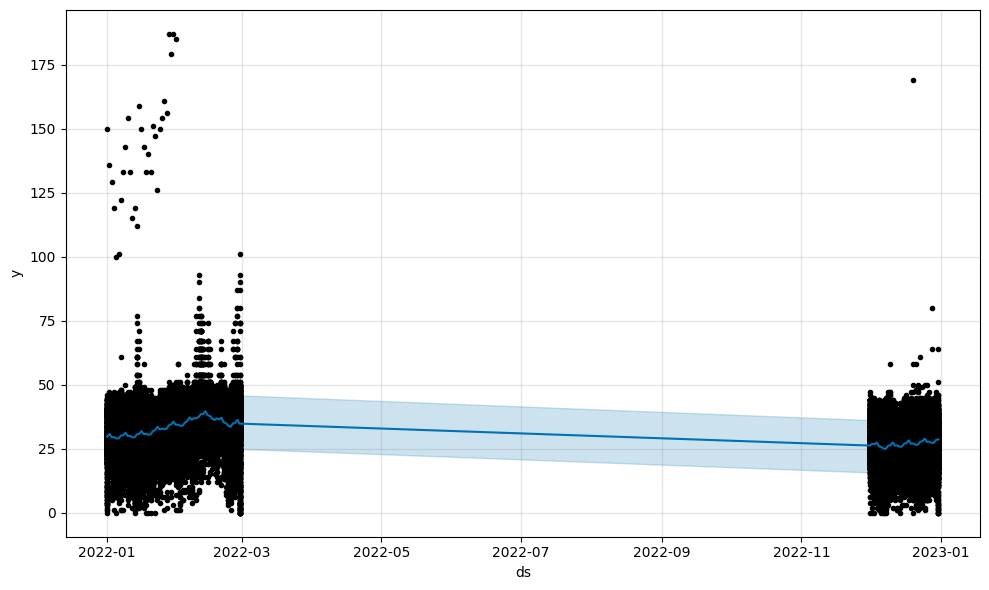

<Figure size 640x480 with 0 Axes>

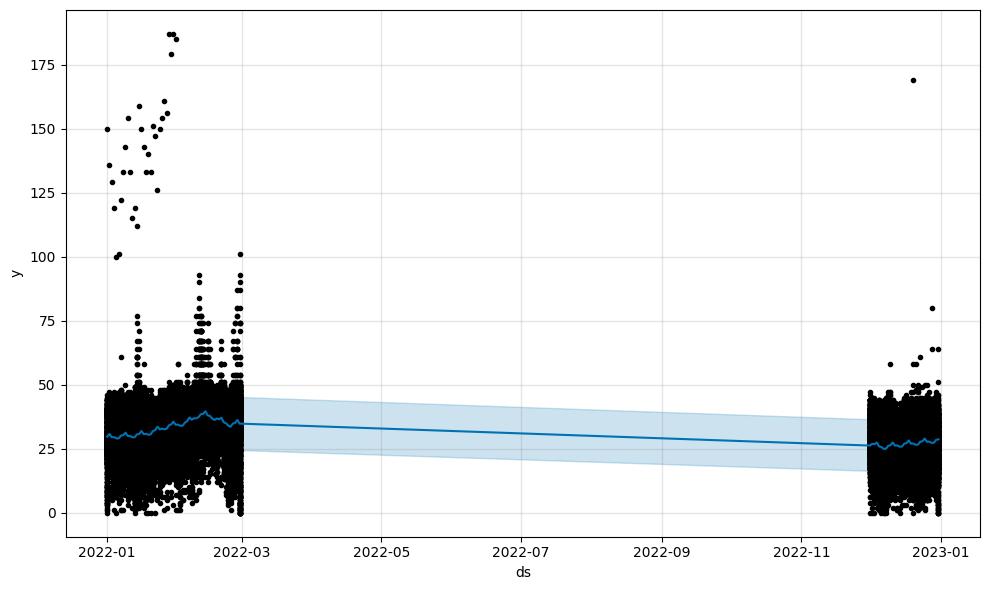

<Figure size 640x480 with 0 Axes>

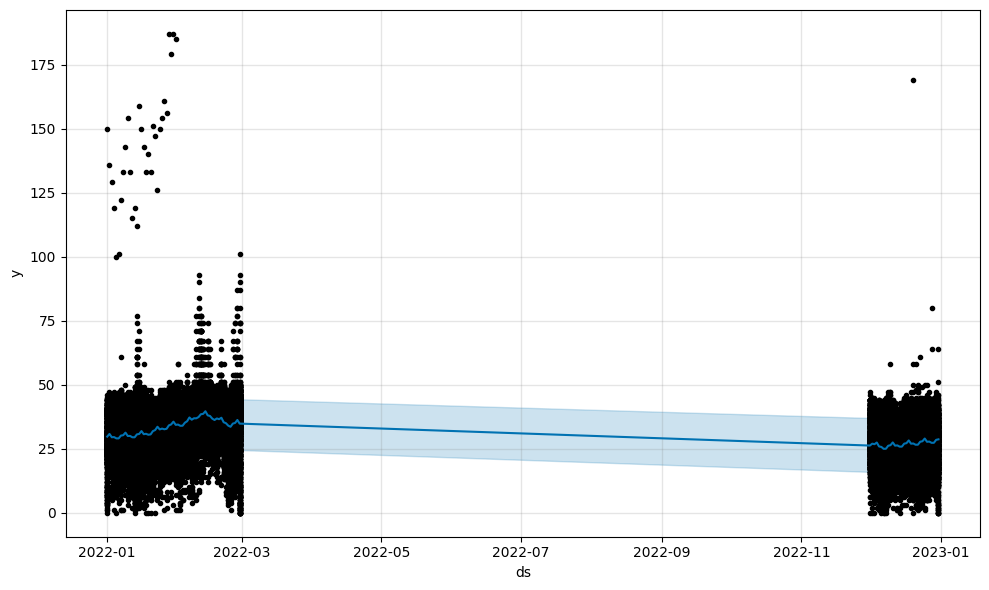

<Figure size 640x480 with 0 Axes>

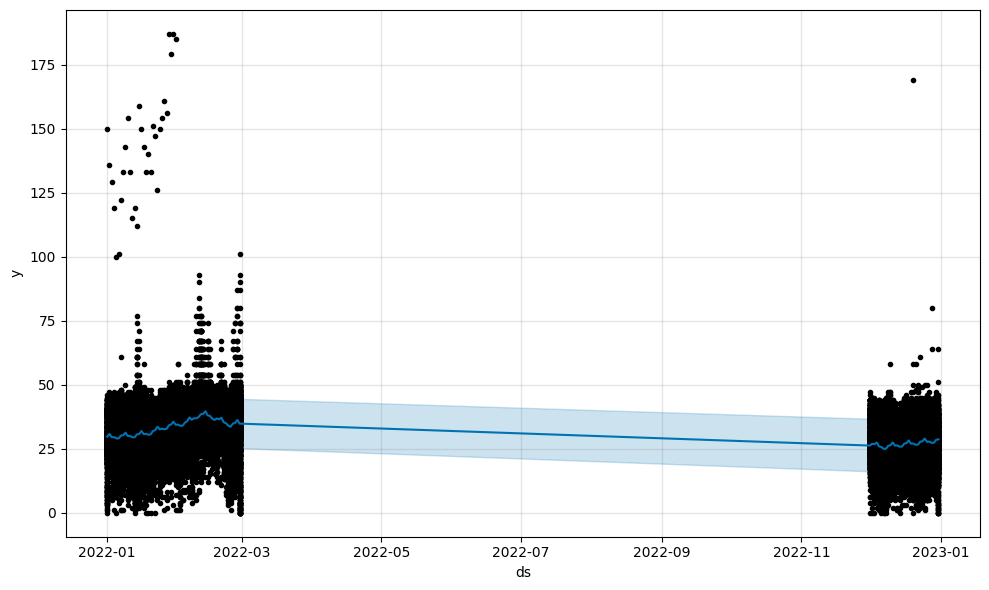

In [ ]:
if __name__ == "__main__":
  path = '/content/data'

  data = pd.read_csv("/content/data/daily_44201_2022.csv")
  data.rename(columns={"Date Local": "Date"}, inplace=True)
  a = Agregation(path, data, 0)
  #False cause it wont execute by spatial unit
  a.execute_seasonal(False)

## Execute the time series analysis for seasons only

In [ ]:
if __name__ == "__main__":
  path = '/content/'

  data = pd.read_csv("/content/grid/100km/2022-final-file.csv")
  data.rename(columns={"Date Local": "Date"}, inplace=True)
  a = Agregation(path, data, 0)

  a.execute_seasonal()

To download the proccessed files so far

In [ ]:
# !zip -r data_seasonal_20231211.zip grid/
!zip -r data_seasonal_unique_unit.zip data/

  adding: data/ (stored 0%)
  adding: data/winter/ (stored 0%)
  adding: data/winter/0-arima.png (deflated 5%)
  adding: data/winter/ts_metrics.csv (deflated 13%)
  adding: data/winter/0-prophet.png (deflated 13%)
  adding: data/winter/final-file.csv (deflated 89%)
  adding: data/fall/ (stored 0%)
  adding: data/fall/0-arima.png (deflated 5%)
  adding: data/fall/ts_metrics.csv (deflated 13%)
  adding: data/fall/0-prophet.png (deflated 13%)
  adding: data/fall/final-file.csv (deflated 89%)
  adding: data/spring/ (stored 0%)
  adding: data/spring/0-arima.png (deflated 5%)
  adding: data/spring/ts_metrics.csv (deflated 13%)
  adding: data/spring/0-prophet.png (deflated 13%)
  adding: data/spring/final-file.csv (deflated 89%)
  adding: data/summer/ (stored 0%)
  adding: data/summer/0-arima.png (deflated 5%)
  adding: data/summer/ts_metrics.csv (deflated 13%)
  adding: data/summer/0-prophet.png (deflated 13%)
  adding: data/summer/final-file.csv (deflated 89%)
  adding: data/daily_44201_202

## Plotting Time series analysis

The next step is for the previous dowloaded data, in case you already have the time series analysis

In [ ]:
!unzip /content/data.zip -d /content/

Archive:  /content/data.zip
   creating: /content/data_new/
   creating: /content/data_new/90km/
  inflating: /content/data_new/90km/83-correlogram.png  
  inflating: /content/data_new/90km/73-correlogram.png  
  inflating: /content/data_new/90km/74-seasonalDecompose.png  
  inflating: /content/data_new/90km/57-TimeSeries.png  
  inflating: /content/data_new/90km/53-arima.png  
  inflating: /content/data_new/90km/84-TimeSeries.png  
  inflating: /content/data_new/90km/52-TimeSeries.png  
  inflating: /content/data_new/90km/49-TimeSeries.png  
  inflating: /content/data_new/90km/58-seasonalDecompose.png  
  inflating: /content/data_new/90km/83-TimeSeries.png  
  inflating: /content/data_new/90km/21-correlogram.png  
  inflating: /content/data_new/90km/78-arima.png  
  inflating: /content/data_new/90km/52-correlogram.png  
  inflating: /content/data_new/90km/58-correlogram.png  
  inflating: /content/data_new/90km/72-arima.png  
  inflating: /content/data_new/90km/75-seasonalDecompose.pn

MAPE mean nan
RMSE mean nan


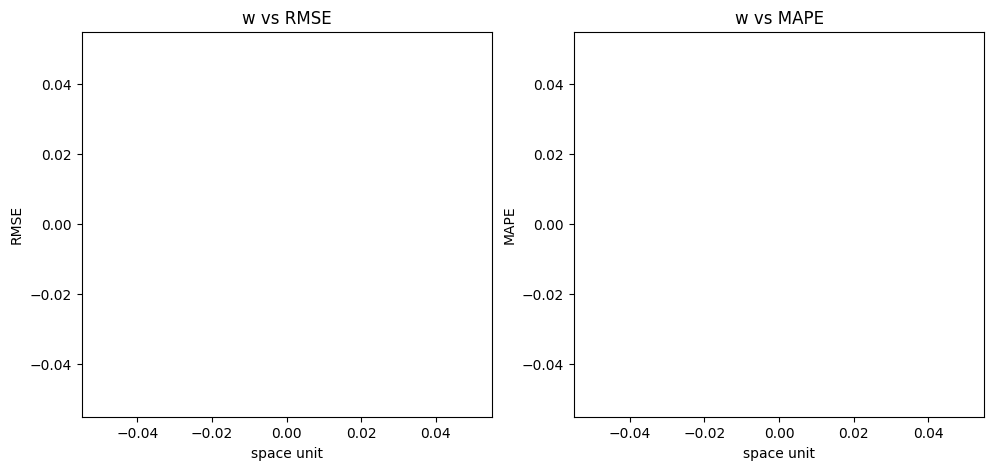

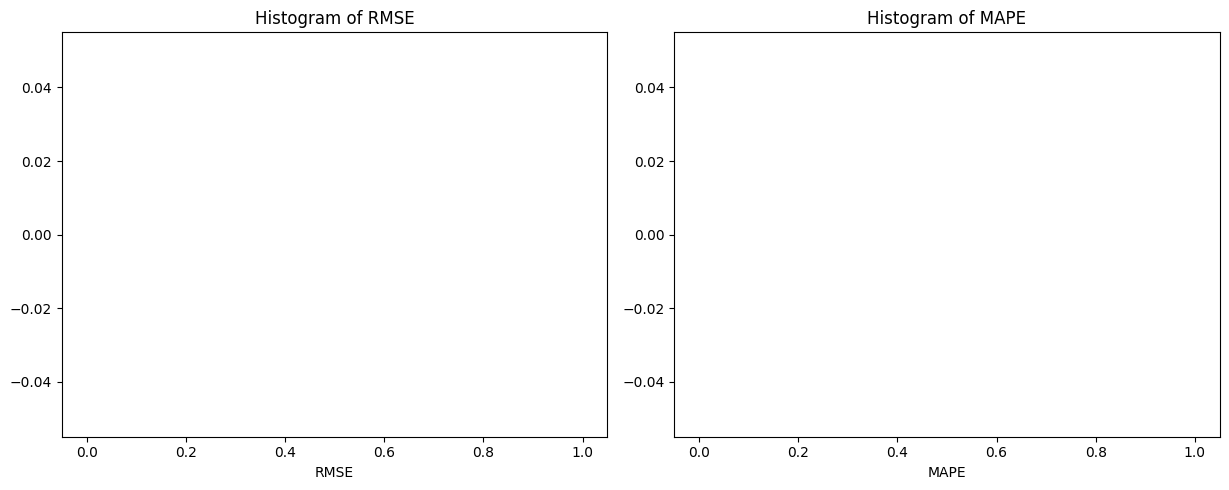

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_csv('/content/grid/90km/arima_metrics.csv')

print("MAPE mean", df['MAPE'].mean())
print("RMSE mean", df['RMSE'].mean())

# Scatter plots
plt.figure(figsize=(18, 5))

# plt.subplot(1, 3, 1)
# plt.scatter(df['w'], df['MSE'])
# plt.xlabel('w')
# plt.ylabel('MSE')
# plt.title('w vs MSE')

plt.subplot(1, 3, 2)
plt.scatter(df['w'], df['RMSE'])
plt.xlabel('space unit')
plt.ylabel('RMSE')
plt.title('w vs RMSE')

plt.subplot(1, 3, 3)
plt.scatter(df['w'], df['MAPE'])
plt.xlabel('space unit')
plt.ylabel('MAPE')
plt.title('w vs MAPE')

# Histograms
plt.figure(figsize=(18, 5))

# plt.subplot(1, 3, 1)
# plt.hist(df['MSE'], bins=15)
# plt.xlabel('MSE')
# plt.title('Histogram of MSE')

plt.subplot(1, 3, 2)
plt.hist(df['RMSE'], bins=15)
plt.xlabel('RMSE')
plt.title('Histogram of RMSE')

plt.subplot(1, 3, 3)
plt.hist(df['MAPE'], bins=15)
plt.xlabel('MAPE')
plt.title('Histogram of MAPE')

plt.tight_layout()
plt.show()


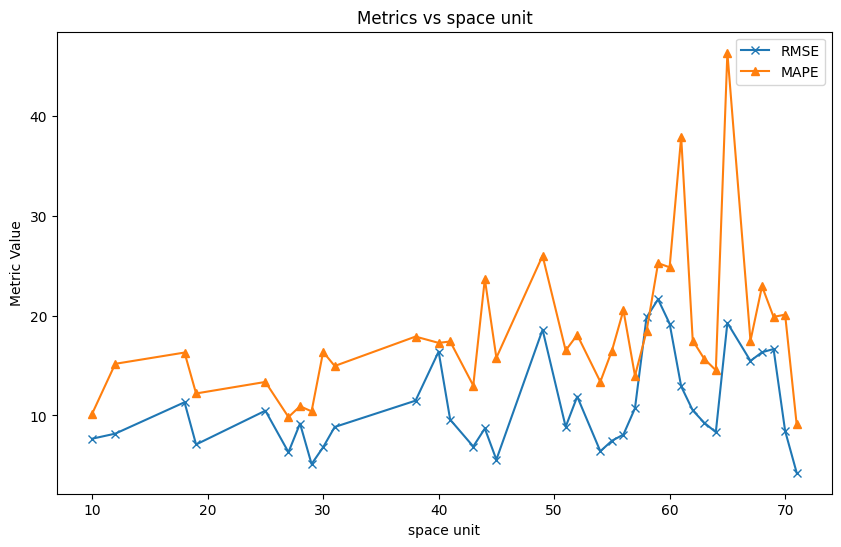

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_csv('/content/data_new/100km/arima_metrics.csv')

# Plotting
plt.figure(figsize=(10, 6))

# Plot each metric as a separate line
# plt.plot(df['w'], df['MSE'], label='MSE', marker='o')
plt.plot(df['w'], df['RMSE'], label='RMSE', marker='x')
plt.plot(df['w'], df['MAPE'], label='MAPE', marker='^')

# Adding labels and title
plt.xlabel('space unit')
plt.ylabel('Metric Value')
plt.title('Metrics vs space unit')
plt.legend()

plt.show()


# Other codes as graphs

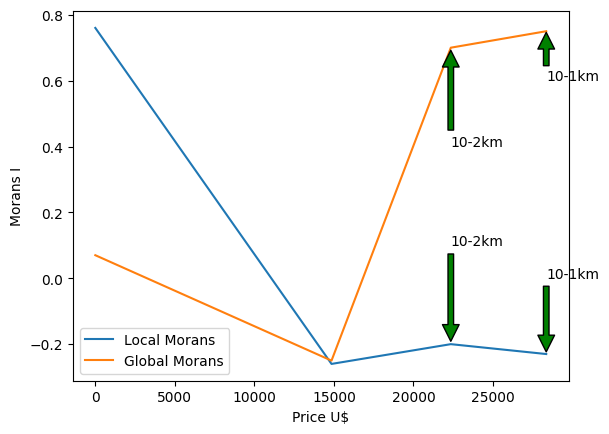

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

data = pd.read_csv('price.csv')
data = data.rename(columns={"Name": "name", "\tSensors": "sensors", "\tMorans Local": "Local Morans",
                           "\tMorans Global": "Global Morans", "\tPrice": "price"})
data.head()

plt.figure()
plt.plot(data['price'], data['Local Morans'], label='Local Morans')
plt.plot(data['price'], data['Global Morans'], label='Global Morans')
plt.xlabel("Price U$")
plt.ylabel("Morans I")
plt.annotate('10-1km', xy =(28350, -0.23),
                xytext =(28350, 0),
                arrowprops = dict(facecolor ='green',
                                  shrink = 0.03),)
plt.annotate('10-2km', xy =(22350, -0.2),
                xytext =(22350, 0.1),
                arrowprops = dict(facecolor ='green',
                                  shrink = 0.03),)
plt.annotate('10-1km', xy =(28350, 0.75),
                xytext =(28350, 0.6),
                arrowprops = dict(facecolor ='green',
                                  shrink = 0.03),)
plt.annotate('10-2km', xy =(22350, 0.7),
                xytext =(22350, 0.4),
                arrowprops = dict(facecolor ='green',
                                  shrink = 0.03),)
plt.legend()
plt.show()